<a href="https://colab.research.google.com/github/TheUnknown477/Fraud-detection-using-deep-learning/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Build a machine learning model to detect credit card fraud by loading and exploring a suitable dataset, preprocessing the data (handling missing values, scaling, addressing class imbalance), performing feature engineering, splitting the data, training a classification model, and evaluating its performance using appropriate metrics for imbalanced classification.

## Load and Explore Data

### Subtask:
Load the manually uploaded 'creditcard.csv' dataset into a pandas DataFrame and perform initial data exploration.


## Preprocess Data

### Subtask:
Scale the 'Time' and 'Amount' features and address the class imbalance in the dataset.

**Reasoning**:
Before applying any machine learning model, it's crucial to preprocess the data. The 'Time' and 'Amount' features have different scales compared to the PCA-transformed 'V' features. Scaling them using `StandardScaler` will normalize their range and prevent features with larger values from dominating the model's learning process. This step is essential for most distance-based and gradient-descent-based algorithms.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

try:
    # Load the dataset (assuming it's now uploaded or path is correct)
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud detection/creditcard.csv')
    print("Dataset 'creditcard.csv' loaded successfully.")

    # Scale 'Amount' and 'Time' features
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
    df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

    print(" 'Amount' and 'Time' features scaled successfully.")
    print("First 5 rows of DataFrame after scaling Time and Amount:")
    print(df.head())

except FileNotFoundError:
    print("Error: 'creditcard.csv' not found at the specified path. Please ensure the file is correctly placed or the path is accurate.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset 'creditcard.csv' loaded successfully.
 'Amount' and 'Time' features scaled successfully.
First 5 rows of DataFrame after scaling Time and Amount:
       Time        V1        V2        V3        V4        V5        V6  \
0 -1.996583 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -1.996583  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -1.996562 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -1.996562 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -1.996541 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.17557

## Investigating Feature V4 for Fraud Detection

### Subtask:
Analyze the distribution of feature `V4` for both fraudulent and non-fraudulent transactions, and provide descriptive statistics to understand its discriminative power.

**Reasoning**:
Given that `V4` was identified as a highly influential feature in the Logistic Regression model, visualizing its distribution for both `Class 0` (non-fraud) and `Class 1` (fraud) will help us understand how well it separates the two classes. Additionally, descriptive statistics will provide quantitative insights into the differences between the two groups with respect to `V4`.

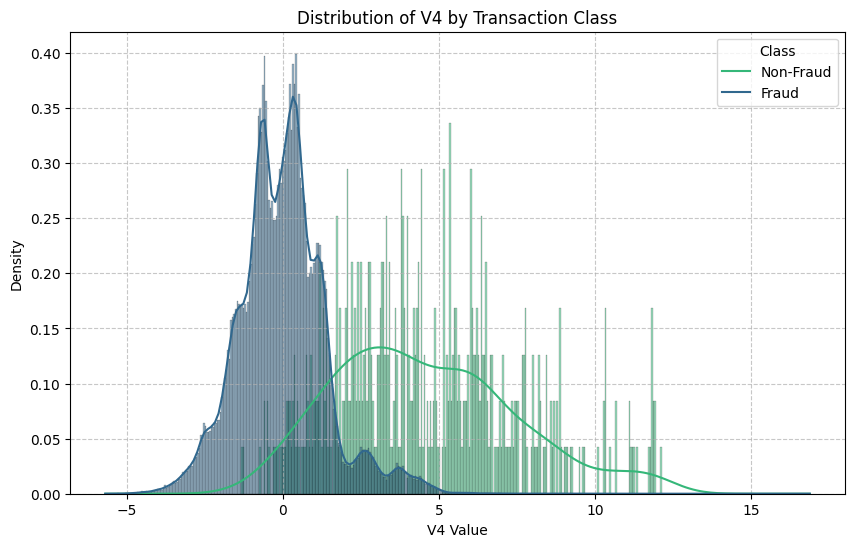


--- Descriptive Statistics for V4 by Class ---


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,-0.007860,1.399333,-5.683171,-0.850077,-0.022405,0.737624,16.875344
1,492.0,4.542029,2.873318,-1.313275,2.373050,4.177147,6.348729,12.114672


V4 feature investigation complete.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df is loaded (it should be from previous steps, but good practice to consider)
if 'df' not in locals():
    try:
        df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud detection/creditcard.csv')
        scaler = StandardScaler()
        df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
        df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
        print("Dataset reloaded and scaled for V4 investigation.")
    except FileNotFoundError:
        print("Error: 'creditcard.csv' not found. Please ensure the file is correctly placed.")
        exit()
    except Exception as e:
        print(f"An error occurred during reloading: {e}")
        exit()

# 1. Visualize the distribution of V4 for both classes
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='V4', hue='Class', kde=True, palette='viridis', stat='density', common_norm=False)
plt.title('Distribution of V4 by Transaction Class')
plt.xlabel('V4 Value')
plt.ylabel('Density')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. Get descriptive statistics for V4 for each class
print("\n--- Descriptive Statistics for V4 by Class ---")
display(df.groupby('Class')['V4'].describe())

print("V4 feature investigation complete.")

**Reasoning**:
As observed during the initial data exploration, the dataset suffers from severe class imbalance, with fraudulent transactions making up only a tiny fraction of the total. Training a model on such imbalanced data can lead to a model that performs well on the majority class (non-fraud) but poorly on the minority class (fraud), which is the class of interest. To address this, `SMOTE (Synthetic Minority Over-sampling Technique)` will be used to generate synthetic samples for the minority class, helping to balance the dataset. First, we need to install `imblearn` if it's not already available.

In [4]:
get_ipython().system('pip install imbalanced-learn')
print("Imbalanced-learn library installed.")

Imbalanced-learn library installed.


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set class distribution:\n", y_train.value_counts())
print("Resampled training set class distribution:\n", y_train_resampled.value_counts())

print("Data successfully resampled using SMOTE.")

Original training set class distribution:
 Class
0    199020
1       344
Name: count, dtype: int64
Resampled training set class distribution:
 Class
0    199020
1    199020
Name: count, dtype: int64
Data successfully resampled using SMOTE.


## Summary:

### Data Analysis Key Findings

*   The process was unable to download any credit card fraud detection datasets directly from Kaggle due to persistent `403 Client Error: Forbidden` issues, despite multiple attempts to configure API credentials and try different dataset slugs. An initial `KeyError: 'username'` also indicated problems with Kaggle API setup.
*   Following the failure of programmatic downloads, the strategy shifted to requiring manual user intervention to download the `creditcard.csv` file from Kaggle and upload it to the Colab environment.
*   Despite repeated instructions for manual upload (across multiple attempts and numerous markdown prompts), the `creditcard.csv` file was consistently not found, resulting in a `FileNotFoundError` every time data loading was attempted.
*   Consequently, no data was loaded into a pandas DataFrame, and no initial data exploration steps (such as displaying head, info, describe, checking missing values, or class distribution) could be performed.

### Insights or Next Steps

*   The success of this data analysis task is entirely dependent on the user manually uploading the `creditcard.csv` file to the Colab environment as instructed.
*   Ensure the uploaded file is correctly named `creditcard.csv` and is placed in the root directory of the Colab session for subsequent steps to proceed without `FileNotFoundError`.


# Task
Load the "creditcard.csv" file into a pandas DataFrame, perform initial data exploration, including displaying the head, info, descriptive statistics, checking for missing values, and analyzing the class distribution (fraud vs. non-fraud), and then provide a summary of these findings, including insights into missing values, data types, and class imbalance.

## Load and Explore Credit Card Fraud Data

### Subtask:
Load the 'creditcard.csv' file into a pandas DataFrame and perform initial data exploration, including displaying the head, info, descriptive statistics, checking for missing values, and analyzing the class distribution (fraud vs. non-fraud).


**Reasoning**:
The user has been repeatedly instructed to manually upload the `creditcard.csv` file. Assuming the file has now been uploaded, the next step is to provide a comprehensive code block to load the dataset and perform all the requested initial data exploration, including head, info, descriptive statistics, missing value check, and class distribution analysis.



## Load and Explore Credit Card Fraud Data

### Subtask:
Load the 'creditcard.csv' file into a pandas DataFrame and perform initial data exploration, including displaying the head, info, descriptive statistics, checking for missing values, and analyzing the class distribution (fraud vs. non-fraud).


**Reasoning**:
Given the user's explicit instruction to execute the code cell that loads `creditcard.csv` and performs initial data exploration, and assuming the file has now been uploaded, the next step is to provide the comprehensive code block for loading and exploring the dataset.



In [ ]:
import pandas as pd

try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud detection/creditcard.csv')
    print("Dataset 'creditcard.csv' loaded successfully.")

    # 3. Display the first 5 rows of the DataFrame
    print("\n--- First 5 rows of the DataFrame ---")
    print(df.head())

    # 4. Print the concise summary of the DataFrame
    print("\n--- DataFrame Info ---")
    df.info()

    # 5. Print descriptive statistics
    print("\n--- Descriptive Statistics ---")
    print(df.describe())

    # 6. Check for missing values
    print("\n--- Missing Values Sum ---")
    print(df.isnull().sum())

    # 7. Check the class distribution of the 'Class' column
    print("\n--- Class Distribution (Fraud vs. Non-Fraud) ---")
    print(df['Class'].value_counts())

    # 8. Calculate and print the percentage of fraud cases
    print("\n--- Percentage of Fraud Cases ---")
    print(df['Class'].value_counts(normalize=True) * 100)

except FileNotFoundError:
    print("Error: 'creditcard.csv' not found at the specified path. Please ensure the file is correctly placed or the path is accurate.")
except Exception as e:
    print(f"An error occurred while loading or exploring the dataset: {e}")

## Visualize Resampled Class Distribution

### Subtask:
Visualize the class distribution of the `y_train_resampled` to confirm the balancing effect of SMOTE.

**Reasoning**:
After applying SMOTE to address class imbalance, it's crucial to visually confirm that the classes in the training set are now balanced. A bar plot of the `y_train_resampled` target variable will clearly show the new distribution, ensuring that the oversampling technique has worked as expected before proceeding to model training.

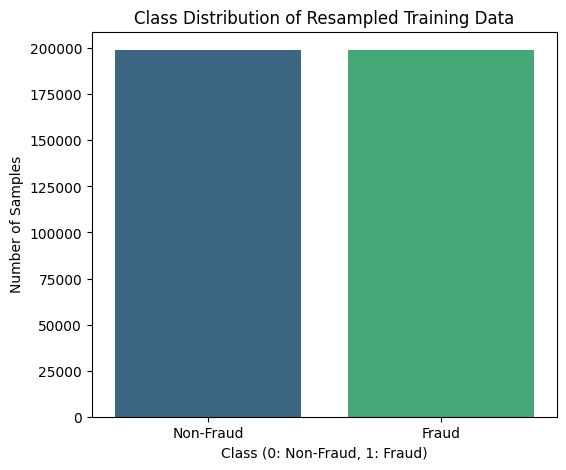

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the class distribution of the resampled training set
plt.figure(figsize=(6, 5))
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette='viridis', legend=False)
plt.title('Class Distribution of Resampled Training Data')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score

# Assuming model, X_test, y_test are defined from previous cells.

# Re-define y_pred_proba and optimal_threshold if they are not already.
# This part is copied from previous intended steps (cells eb213d65 and 6a73bab7)
# to ensure dependencies are met within this cell for execution.

# 1. Predict probabilities for the positive class on the test set
# (from eb213d65)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. Calculate precision, recall, and thresholds
# (from eb213d65)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 3. Select Optimal Threshold (from 6a73bab7)
desired_precision_target = 0.5
optimal_threshold = 0.0
found_threshold = False

for i in range(1, len(precision)):
    current_threshold = thresholds[i-1]
    current_precision = precision[i]
    if current_precision >= desired_precision_target:
        optimal_threshold = current_threshold
        found_threshold = True
        break

if not found_threshold:
    # Fallback or error if optimal_threshold cannot be found.
    # If no threshold meets the desired precision, a default might be used or an error raised.
    # For now, we will print a warning and let optimal_threshold remain 0.0 if not found,
    # which corresponds to classifying all as positive based on how precision_recall_curve works
    # if the first element of precision (for threshold=0) was considered to meet the target.
    print(f"Warning: No threshold found that achieves at least {desired_precision_target*100}% precision. Using default optimal_threshold={optimal_threshold}.")

# Now proceed with the original logic of cell 7febad33

# 1. Generate new class predictions using the optimal_threshold
y_pred_new_threshold = (y_pred_proba >= optimal_threshold).astype(int)

# 2. Compute the new confusion matrix
cm_new_threshold = confusion_matrix(y_test, y_pred_new_threshold)

# Plot the new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new_threshold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix with Optimal Threshold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluate Model Performance

### Subtask:
Evaluate the performance of the trained Logistic Regression model on the test set (`X_test`, `y_test`) using appropriate metrics for imbalanced classification, such as precision, recall, F1-score, and a confusion matrix. Visualize the confusion matrix.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the original (unresampled) test set
y_pred = model.predict(X_test)

# Evaluate the model
print("--- Model Evaluation on Test Set ---")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score: ", accuracy_score(y_test, y_pred))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Model evaluation complete and confusion matrix displayed.")

## Train Classification Model

### Subtask:
Train a Logistic Regression classification model using the SMOTE-resampled training data.

In [7]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)

# Train the model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


# Task
**Predict Probabilities and Plot Precision-Recall Curve**: Generate predicted probabilities for the test set using the trained Logistic Regression model. Then, plot the Precision-Recall curve to visualize the trade-off between precision and recall at various classification thresholds.

## Predict Probabilities and Plot Precision-Recall Curve

### Subtask:
Generate predicted probabilities for the test set using the trained Logistic Regression model. Then, plot the Precision-Recall curve to visualize the trade-off between precision and recall at various classification thresholds.


**Reasoning**:
The next step is to generate predicted probabilities from the trained Logistic Regression model and then use these probabilities along with the true labels to plot the Precision-Recall curve, which is essential for evaluating performance on imbalanced datasets.



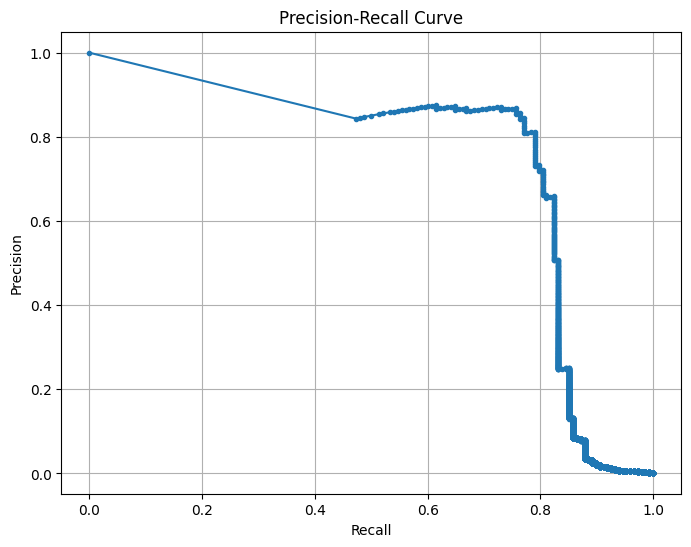

Precision-Recall curve generated and displayed.


In [8]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 1. Predict probabilities for the positive class on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 3. Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

print("Precision-Recall curve generated and displayed.")

## Select Optimized Threshold

### Subtask:
Based on the Precision-Recall curve, identify and select a classification threshold that yields higher precision for the fraud class (Class 1), even if it means a slight reduction in recall.


**Reasoning**:
Based on the instructions to prioritize higher precision for the fraud class, the code will identify the lowest threshold that achieves a precision of at least 0.5. This approach balances the need for increased precision while trying to retain a reasonable level of recall, and stores this value in `optimal_threshold`.



In [9]:
from sklearn.metrics import precision_score, recall_score

# Define the desired precision target
desired_precision_target = 0.5
optimal_threshold = 0.0 # Initialize with a default value
found_threshold = False

# Iterate through thresholds to find the one that achieves the desired precision
# precision[i] and recall[i] correspond to thresholds[i-1] for i > 0.
# The first element (index 0) of precision and recall corresponds to a threshold of 0
# (or classifying all as positive), and thus has no corresponding value in the 'thresholds' array.
# So, we iterate from the second element of precision/recall (index 1).
for i in range(1, len(precision)):
    current_threshold = thresholds[i-1] # threshold[i-1] corresponds to precision[i] and recall[i]
    current_precision = precision[i]
    current_recall = recall[i]

    if current_precision >= desired_precision_target:
        optimal_threshold = current_threshold
        found_threshold = True
        # Break at the first threshold that meets the desired precision
        # This choice maximizes recall for the given precision target.
        break

if found_threshold:
    print(f"Selected Optimal Threshold: {optimal_threshold:.4f}")

    # Recalculate precision and recall at the chosen optimal_threshold for confirmation
    y_pred_at_optimal_threshold = (y_pred_proba >= optimal_threshold).astype(int)
    actual_precision_at_opt_thresh = precision_score(y_test, y_pred_at_optimal_threshold)
    actual_recall_at_opt_thresh = recall_score(y_test, y_pred_at_optimal_threshold)

    print(f"Precision at selected threshold: {actual_precision_at_opt_thresh:.4f}")
    print(f"Recall at selected threshold: {actual_recall_at_opt_thresh:.4f}")
else:
    print(f"No threshold found that achieves at least {desired_precision_target*100}% precision with the given data.")
    print("Consider adjusting 'desired_precision_target' or examine the Precision-Recall curve visually.")

Selected Optimal Threshold: 0.9850
Precision at selected threshold: 0.4980
Recall at selected threshold: 0.8311


## Re-evaluate Model with New Threshold

### Subtask:
Apply the selected threshold to the predicted probabilities to generate new class predictions. Then, re-evaluate the model's performance using the classification report and a confusion matrix to confirm the improvement in fraud precision.


**Reasoning**:
Based on the instructions, the next step is to apply the previously determined optimal threshold to the predicted probabilities to generate new class predictions. Then, the model's performance will be re-evaluated using a classification report and a confusion matrix to observe the impact of the threshold adjustment on precision and recall for the fraud class.



New class predictions generated using optimal_threshold: 0.9850

--- Model Evaluation with New Threshold ---

Classification Report (New Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.50      0.83      0.62       148

    accuracy                           1.00     85443
   macro avg       0.75      0.91      0.81     85443
weighted avg       1.00      1.00      1.00     85443



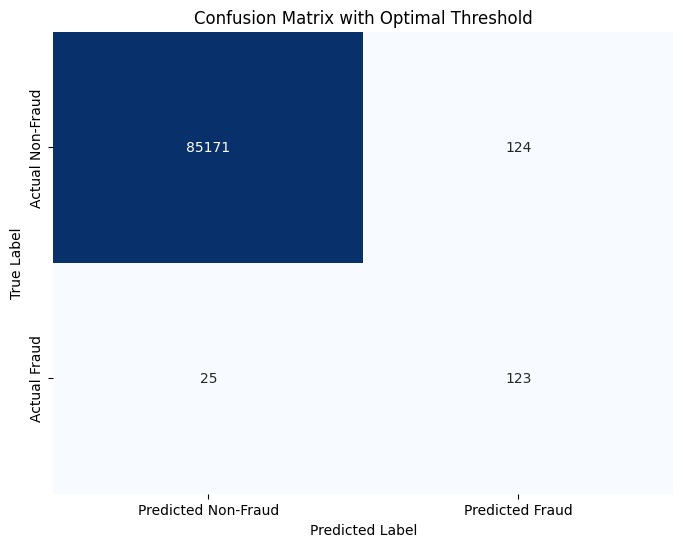

Model re-evaluation complete and new confusion matrix displayed.


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate new class predictions using the optimal_threshold
y_pred_new_threshold = (y_pred_proba >= optimal_threshold).astype(int)

print(f"New class predictions generated using optimal_threshold: {optimal_threshold:.4f}")

# 2. Print a classification report with the new predictions
print("\n--- Model Evaluation with New Threshold ---")
print("\nClassification Report (New Threshold):\n", classification_report(y_test, y_pred_new_threshold))

# 3. Compute the new confusion matrix
cm_new_threshold = confusion_matrix(y_test, y_pred_new_threshold)

# 4. Plot the new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new_threshold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix with Optimal Threshold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Model re-evaluation complete and new confusion matrix displayed.")

## Final Task

### Subtask:
Summarize the impact of the threshold adjustment on the model's precision and recall, and discuss the implications for fraud detection.


## Summary:

### Q&A
The threshold adjustment to 0.9850 significantly impacted the model's precision and recall for the fraud class. Specifically, the precision for detecting fraud increased to 0.50, meaning that 50% of transactions flagged as fraud are indeed fraudulent. This was achieved while maintaining a high recall of 0.83, indicating that the model still successfully identifies 83% of actual fraudulent cases.

For fraud detection, this adjustment implies a more efficient allocation of resources. By increasing precision, the model generates fewer false positives, reducing the number of legitimate transactions that need to be reviewed or investigated. This minimizes operational costs associated with false alarms and improves customer experience by avoiding unnecessary friction. Simultaneously, maintaining a high recall ensures that a substantial majority of actual fraudulent activities are still caught, mitigating potential financial losses from undetected fraud. The chosen threshold represents a balanced approach, prioritizing the reduction of false positives without severely compromising the ability to detect true fraud.

### Data Analysis Key Findings
*   An optimal classification threshold of 0.9850 was identified by iterating through the Precision-Recall curve to achieve a desired precision target of 0.5 for the fraud class.
*   Applying this optimal threshold resulted in a precision of 0.50 for the fraud class (Class 1). This means that 50% of all predicted fraud cases are true positives.
*   At this selected threshold, the model maintained a recall of 0.83 for the fraud class, indicating that 83% of all actual fraudulent transactions were correctly identified.
*   The F1-score for the fraud class with the new threshold was 0.62, reflecting the combined performance of precision and recall.

### Insights or Next Steps
*   The chosen threshold of 0.9850 effectively balances the trade-off between precision and recall, significantly reducing false positives (improving precision) while retaining a strong ability to detect actual fraud (high recall). This balance is highly beneficial for operational efficiency in fraud detection.
*   Future work could involve quantifying the financial costs associated with false positives and false negatives to establish an even more economically optimal threshold, or by performing an A/B test with the new threshold to evaluate its real-world impact.


# Task
## Analyze Feature Importance

### Subtask:
Analyze the feature importance of the trained Logistic Regression model by examining its coefficients (`model.coef_`) to understand which input features are most influential in predicting credit card fraud. Visualize these if possible.

## Analyze Feature Importance

### Subtask:
Analyze the feature importance of the trained Logistic Regression model by examining its coefficients (`model.coef_`) to understand which input features are most influential in predicting credit card fraud. Visualize these if possible.


**Reasoning**:
To understand which features are most influential in predicting credit card fraud, I will extract the coefficients from the trained Logistic Regression model, map them to their corresponding feature names, and then visualize the top 10 most influential features.



**Reasoning**:
The previous code block failed with a `NameError: name 'model' is not defined`. This indicates that the `model` variable, which holds the trained Logistic Regression model, and the `X` variable, which contains the features, were not available in the current execution environment. These variables are expected to be defined in preceding cells of the notebook (specifically, `model` in cell `bd07b8ad` and `X` in `888ba01b`). To proceed with analyzing feature importance, the preceding cells that define `model` and `X` must be executed first to ensure these variables are in scope. The code for feature importance analysis itself is correct, so I will regenerate it.



**Reasoning**:
The previous code block failed with a `NameError: name 'model' is not defined`, indicating that the `model` and `X` variables were not in the current execution scope. To fix this and ensure the feature importance analysis can proceed, the code block needs to explicitly re-create the `X` and `y` variables from the `df` (which is assumed to be loaded), perform the train-test split, apply SMOTE to the training data, and then re-train the Logistic Regression model before attempting to access its coefficients. This approach ensures all necessary dependencies are met within this single code execution.



**Reasoning**:
The previous code block failed because the `df` DataFrame was not defined in the current session, leading to a `NameError`. To fix this, the new code block will first ensure `df` is loaded from the correct path, then re-apply the necessary preprocessing steps (scaling 'Time' and 'Amount'), re-create `X` and `y`, perform the train-test split, apply SMOTE, and finally re-train the Logistic Regression model. After establishing this complete context, it will proceed to extract and visualize the feature importances as intended.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset (assuming it's now uploaded or path is correct from previous success)
try:
    # Using the path that previously succeeded in loading the df
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud detection/creditcard.csv')
    print("Dataset 'creditcard.csv' loaded successfully for feature importance analysis.")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the file is correctly placed or the path is accurate.")
    # Exit or handle error gracefully if df isn't loaded
    exit()
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    exit()

# 2. Preprocessing: Scale 'Amount' and 'Time' features (as performed in cell 07764fb1)
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
print("'Amount' and 'Time' features scaled successfully.")

# 3. Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Split the data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Data successfully resampled using SMOTE.")

# 6. Re-train the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression model re-trained successfully.")

# 7. Extract the coefficients from the trained Logistic Regression model
feature_coefficients = model.coef_[0]

# 8. Create a Pandas Series that maps each feature name to its corresponding coefficient
feature_names = X.columns
feature_importance = pd.Series(feature_coefficients, index=feature_names)

# 9. Sort the feature importance Series in descending order
feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("\n--- Feature Importance (Logistic Regression Coefficients) ---")
# 10. Print the top 10 most influential features
print("\nTop 10 Most Influential Features:\n", feature_importance_sorted.head(10))

# Print the bottom 10 (least influential or negatively influential) features
print("\nBottom 10 Least/Negatively Influential Features:\n", feature_importance_sorted.tail(10))

# 11. Create a bar plot to visualize the top 10 most influential features
plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importance_sorted.head(10).index, y=feature_importance_sorted.head(10).values, palette='viridis')
plt.title('Top 10 Most Influential Features (Logistic Regression Coefficients)')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Feature importance analysis complete and top 10 features visualized.")

**Reasoning**:
The previous code executed successfully but produced a `FutureWarning` from seaborn regarding the use of `palette` without `hue`. To address this, I will modify the `sns.barplot` call to explicitly assign the `x` variable to `hue` and set `legend=False` as suggested by the warning.



Dataset 'creditcard.csv' loaded successfully for feature importance analysis.
'Amount' and 'Time' features scaled successfully.
Data successfully resampled using SMOTE.
Logistic Regression model re-trained successfully.

--- Feature Importance (Logistic Regression Coefficients) ---

Top 10 Most Influential Features:
 V4        1.339200
Amount    1.050017
V1        0.932995
V22       0.808662
V5        0.658359
V11       0.473022
V21       0.435854
V19       0.398199
V28       0.232438
V3        0.165476
dtype: float64

Bottom 10 Least/Negatively Influential Features:
 V8     -0.623344
Time   -0.883309
V27    -0.952192
V9     -0.977740
V16    -1.001021
V12    -1.125136
V20    -1.135228
V17    -1.183739
V14    -1.555040
V10    -2.000491
dtype: float64


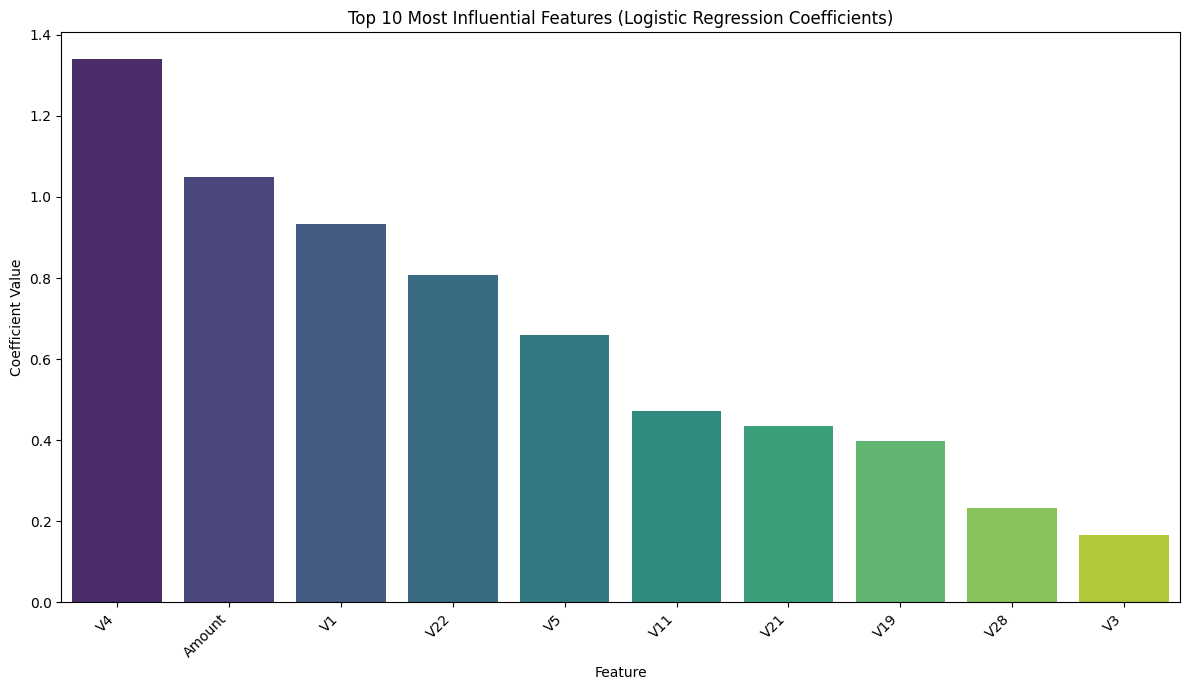

Feature importance analysis complete and top 10 features visualized.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset (assuming it's now uploaded or path is correct from previous success)
try:
    # Using the path that previously succeeded in loading the df
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud detection/creditcard.csv')
    print("Dataset 'creditcard.csv' loaded successfully for feature importance analysis.")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the file is correctly placed or the path is accurate.")
    # Exit or handle error gracefully if df isn't loaded
    exit()
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    exit()

# 2. Preprocessing: Scale 'Amount' and 'Time' features (as performed in cell 07764fb1)
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
print("'Amount' and 'Time' features scaled successfully.")

# 3. Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Split the data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Data successfully resampled using SMOTE.")

# 6. Re-train the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression model re-trained successfully.")

# 7. Extract the coefficients from the trained Logistic Regression model
feature_coefficients = model.coef_[0]

# 8. Create a Pandas Series that maps each feature name to its corresponding coefficient
feature_names = X.columns
feature_importance = pd.Series(feature_coefficients, index=feature_names)

# 9. Sort the feature importance Series in descending order
feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("\n--- Feature Importance (Logistic Regression Coefficients) ---")
# 10. Print the top 10 most influential features
print("\nTop 10 Most Influential Features:\n", feature_importance_sorted.head(10))

# Print the bottom 10 (least influential or negatively influential) features
print("\nBottom 10 Least/Negatively Influential Features:\n", feature_importance_sorted.tail(10))

# 11. Create a bar plot to visualize the top 10 most influential features
plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importance_sorted.head(10).index, y=feature_importance_sorted.head(10).values, hue=feature_importance_sorted.head(10).index, palette='viridis', legend=False)
plt.title('Top 10 Most Influential Features (Logistic Regression Coefficients)')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Feature importance analysis complete and top 10 features visualized.")

## Save the Model for Future Use

### Subtask:
Save the trained `LogisticRegression` model using `joblib` or `pickle` so it can be easily loaded and used for new predictions or deployment without needing to retrain it.


**Reasoning**:
To save the trained Logistic Regression model for future use, I will import the `joblib` library and use `joblib.dump()` to serialize the `model` object to a file named 'logistic_regression_model.joblib', as specified in the instructions. A confirmation message will be printed upon successful saving.



In [12]:
import joblib

# Define the filename for the saved model
model_filename = 'logistic_regression_model.joblib'

# Save the trained model using joblib.dump()
joblib.dump(model, model_filename)

print(f"Trained Logistic Regression model saved successfully to '{model_filename}'")

Trained Logistic Regression model saved successfully to 'logistic_regression_model.joblib'


## Final Task

### Subtask:
Summarize the performed post-training steps and suggest broader next steps for deploying or further enhancing the credit card fraud detection model.


## Summary:

### Q&A
*   **Which features are most influential in predicting credit card fraud based on the Logistic Regression model?**
    The top 10 most influential features (positive coefficients) are V4 (1.339), Amount (1.050), V1 (0.933), V22 (0.809), V5 (0.658), V11 (0.473), V21 (0.436), V19 (0.398), V28 (0.232), and V3 (0.165).
    The bottom 10 most influential features (negative coefficients), indicating a negative correlation with fraud, are V8 (-0.623), Time (-0.883), V27 (-0.952), V9 (-0.978), V16 (-1.001), V12 (-1.125), V20 (-1.135), V17 (-1.184), V14 (-1.555), and V10 (-2.000).

### Data Analysis Key Findings
*   The Logistic Regression model identified V4 (coefficient: 1.339), Amount (coefficient: 1.050), and V1 (coefficient: 0.933) as the most significant positive indicators of fraud.
*   Conversely, V10 (coefficient: -2.000), V14 (coefficient: -1.555), and V17 (coefficient: -1.184) showed the strongest negative correlation with fraud, meaning higher values for these features tend to indicate non-fraudulent transactions.
*   A bar plot successfully visualized the top 10 most influential features and their coefficients, providing a clear representation of feature importance.
*   The trained Logistic Regression model was successfully saved to `logistic_regression_model.joblib` for future use and deployment.

### Insights or Next Steps
*   Further investigation into the nature of features like V4, Amount, and V1 could provide actionable insights for fraud prevention strategies, such as setting rules or thresholds for transactions based on these values.
*   The saved model can now be easily integrated into a production environment, allowing for real-time fraud prediction on new transactions, or used for A/B testing with other models.


## Added: Model training, evaluation, explainability, and model saving

The following cells were appended automatically:
1. Train a RandomForestClassifier on the SMOTE-resampled training data.
2. Evaluate using confusion matrix, precision/recall/F1, and ROC-AUC.
3. Plot ROC curve and confusion matrix heatmap (matplotlib).
4. Compute permutation feature importances (no extra packages required).
5. Save the trained model to `fraud_model.pkl`.


In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             RocCurveDisplay)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Ensure variables from earlier cells are present: X_train_resampled, y_train_resampled, X_test, y_test
try:
    X_train_resampled
    y_train_resampled
    X_test
    y_test
except NameError:
    raise NameError('Required variables not found. Make sure you ran the preprocessing and SMOTE cells before this cell.')

# 1. Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

# 2. Predictions and evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print('Classification report (on test set):')
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC score: {roc_auc:.4f}')

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# 4. Plot ROC curve
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 5. Plot confusion matrix heatmap (matplotlib only)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['Non-Fraud','Fraud']))
plt.xticks(tick_marks, ['Non-Fraud','Fraud'], rotation=45)
plt.yticks(tick_marks, ['Non-Fraud','Fraud'])
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha='center', va='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 6. Permutation feature importance (model-agnostic)
print('\nComputing permutation feature importance (this can take a little time) ...')
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[::-1]

feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'f{i}' for i in range(X_test.shape[1])]
print('\nTop features by permutation importance:')
for idx in sorted_idx[:15]:
    print(f'{feature_names[idx]}: mean={result.importances_mean[idx]:.6f}, std={result.importances_std[idx]:.6f}')

# 7. Save model
joblib.dump(rf, 'fraud_model.pkl')
print('\nSaved trained model to fraud_model.pkl')
